Gerekli K√ºt√ºphanelerin Y√ºklenmesi

In [3]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize


1. Adƒ±m ‚Äì Veri Hazƒ±rlama

In [5]:
# üìÇ Meta veri setinin yolu
base_dir = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin"

# üìÇ Meta dosyalarƒ±nƒ±n yollarƒ±
meta_paths = {
    "Beauty": os.path.join(base_dir, "meta_All_Beauty.jsonl.gz"),
    "Digital_Music": os.path.join(base_dir, "meta_Digital_Music.jsonl.gz"),
    "Health_and_Personal_Care": os.path.join(base_dir, "meta_Health_and_Personal_Care.jsonl.gz"),
}

# üìë Meta veri setlerini oku ve birle≈ütir
meta_dfs = []
for category, path in meta_paths.items():
    df = pd.read_json(path, lines=True, compression="gzip")
    df["category"] = category
    meta_dfs.append(df)

df_meta = pd.concat(meta_dfs, ignore_index=True)

# üìù Metin Temizleme Fonksiyonu
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\W+', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

# üìå Metin s√ºtunlarƒ±nƒ± birle≈ütir ve temizle
df_meta["clean_text"] = df_meta["title"].astype(str) + " " + df_meta["details"].astype(str)
df_meta["clean_text"] = df_meta["clean_text"].apply(clean_text)

print("‚úÖ Veri hazƒ±rlama tamamlandƒ±.")

‚úÖ Veri hazƒ±rlama tamamlandƒ±.


2. Adƒ±m ‚Äì TF-IDF ile Metin Vekt√∂rle≈ütirme

In [7]:
# üîπ TF-IDF Vekt√∂rizasyon
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df_meta["clean_text"])

print("‚úÖ TF-IDF vekt√∂rle≈ütirme tamamlandƒ±.")

‚úÖ TF-IDF vekt√∂rle≈ütirme tamamlandƒ±.


 3. Adƒ±m ‚Äì ResNet50 ile G√∂rsel √ñzellik √áƒ±karma

In [9]:
# üìÇ G√∂rsellerin olduƒüu klas√∂r
image_dir = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/preprocessed_images"

# üîπ ResNet50 Modelini Y√ºkle
resnet_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

# üîπ G√∂rsel embedding'leri √ßƒ±karalƒ±m
image_embeddings = []
for _, row in tqdm(df_meta.iterrows(), total=len(df_meta)):
    img_path = os.path.join(image_dir, row["category"], f"{row['parent_asin']}.jpg")
    if os.path.exists(img_path):
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        embedding = resnet_model.predict(img_array)
        image_embeddings.append(embedding.flatten())
    else:
        image_embeddings.append(np.zeros((2048,)))

image_embeddings = np.array(image_embeddings)
print("‚úÖ G√∂rsel embedding'leri √ßƒ±karƒ±ldƒ±.")

2025-03-01 15:06:27.824694: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-03-01 15:06:27.824719: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-03-01 15:06:27.824723: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-03-01 15:06:27.824740: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-01 15:06:27.824748: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 243420/243420 [00:04<00:00, 50867.54it/s]


‚úÖ G√∂rsel embedding'leri √ßƒ±karƒ±ldƒ±.


Hybrid Model ile √ñneri

In [11]:
# üîπ PCA ile Metin Embeddinglerini 2048 Boyutuna D√º≈ü√ºr (G√∂rsel ile E≈üitlemek ƒ∞√ßin)
pca_text = PCA(n_components=2048, random_state=42)
text_embeddings_reduced = pca_text.fit_transform(tfidf_matrix.toarray())  # TF-IDF genelde sparse olur, bu y√ºzden toarray() kullanƒ±yoruz.

# üîπ Embedding'leri Normalize Et
text_embeddings_reduced = normalize(text_embeddings_reduced)  # TF-IDF metin vekt√∂rleri
image_embeddings = normalize(image_embeddings)  # G√∂rseller zaten 2048 boyutunda

# üîπ Hybrid Embedding Hesapla
alpha = 0.5  # Metin ve G√∂rsel katkƒ±sƒ±nƒ± dengeleme fakt√∂r√º
hybrid_embeddings = alpha * text_embeddings_reduced + (1 - alpha) * image_embeddings

print("‚úÖ Hybrid embedding'ler ba≈üarƒ±yla olu≈üturuldu!")

‚úÖ Hybrid embedding'ler ba≈üarƒ±yla olu≈üturuldu!


1. Hybrid Cosine Similarity Hesapla ve Kaydet

In [13]:
# üîπ Mini-Batch Ayarlarƒ± (Kernel √ß√∂kmesini √∂nlemek i√ßin)
batch_size = 5000  # Daha k√º√ß√ºk par√ßalar halinde hesaplayalƒ±m

# üîπ En benzer 10 √ºr√ºn√º saklayacaƒüƒ±mƒ±z bir yapƒ±
num_samples = hybrid_embeddings.shape[0]
top_k = 10  # Her √ºr√ºn i√ßin en benzer 10 √ºr√ºn√º alacaƒüƒ±z
hybrid_similarity_results = np.zeros((num_samples, top_k))

# üîπ Mini-Batch Cosine Similarity Hesaplama
for start in range(0, num_samples, batch_size):
    end = min(start + batch_size, num_samples)
    batch_vectors = hybrid_embeddings[start:end]

    print(f"ƒ∞≈üleniyor: {start} - {end} / {num_samples}")
    
    # ‚úÖ Hybrid Cosine Similarity Hesaplama (Sadece bu batch i√ßin)
    batch_similarity = cosine_similarity(batch_vectors, hybrid_embeddings)

    # ‚úÖ En y√ºksek 10 benzerliƒüi sakla (Bellek kullanƒ±mƒ±nƒ± azalt)
    for i, row in enumerate(batch_similarity):
        top_indices = np.argsort(row)[-top_k:]  # En y√ºksek 10 benzerliƒüi al
        hybrid_similarity_results[start + i] = top_indices

# ‚úÖ **Benzerlik sonu√ßlarƒ±nƒ± farklƒ± bir dosyaya kaydet**
hybrid_similarity_path = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/hybrid_similarity_results.npy"
np.save(hybrid_similarity_path, hybrid_similarity_results)

print("‚úÖ Hybrid Cosine Similarity hesaplama tamamlandƒ± ve kaydedildi! Dosya adƒ±: hybrid_similarity_results.npy")

ƒ∞≈üleniyor: 0 - 5000 / 243420
ƒ∞≈üleniyor: 5000 - 10000 / 243420
ƒ∞≈üleniyor: 10000 - 15000 / 243420
ƒ∞≈üleniyor: 15000 - 20000 / 243420
ƒ∞≈üleniyor: 20000 - 25000 / 243420
ƒ∞≈üleniyor: 25000 - 30000 / 243420
ƒ∞≈üleniyor: 30000 - 35000 / 243420
ƒ∞≈üleniyor: 35000 - 40000 / 243420
ƒ∞≈üleniyor: 40000 - 45000 / 243420
ƒ∞≈üleniyor: 45000 - 50000 / 243420
ƒ∞≈üleniyor: 50000 - 55000 / 243420
ƒ∞≈üleniyor: 55000 - 60000 / 243420
ƒ∞≈üleniyor: 60000 - 65000 / 243420
ƒ∞≈üleniyor: 65000 - 70000 / 243420
ƒ∞≈üleniyor: 70000 - 75000 / 243420
ƒ∞≈üleniyor: 75000 - 80000 / 243420
ƒ∞≈üleniyor: 80000 - 85000 / 243420
ƒ∞≈üleniyor: 85000 - 90000 / 243420
ƒ∞≈üleniyor: 90000 - 95000 / 243420
ƒ∞≈üleniyor: 95000 - 100000 / 243420
ƒ∞≈üleniyor: 100000 - 105000 / 243420
ƒ∞≈üleniyor: 105000 - 110000 / 243420
ƒ∞≈üleniyor: 110000 - 115000 / 243420
ƒ∞≈üleniyor: 115000 - 120000 / 243420
ƒ∞≈üleniyor: 120000 - 125000 / 243420
ƒ∞≈üleniyor: 125000 - 130000 / 243420
ƒ∞≈üleniyor: 130000 - 135000 / 243420
ƒ∞≈üleniyor: 135000

In [21]:
import numpy as np
import os

# üìÇ Kaydedilen dosyanƒ±n yolu
hybrid_similarity_results_path = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/hybrid_similarity_results.npy"

# ‚úÖ Kernel √ß√∂kerse hesaplama yapmadan kaydedilen dosyayƒ± y√ºkle
if os.path.exists(hybrid_similarity_results_path):
    hybrid_similarity_results = np.load(hybrid_similarity_results_path)
    print("‚úÖ Kaydedilmi≈ü Hybrid Cosine Similarity sonu√ßlarƒ± ba≈üarƒ±yla y√ºklendi.")
else:
    raise FileNotFoundError("‚ùå hybrid_similarity_results.npy bulunamadƒ±! √ñnce hesaplama yapmalƒ±sƒ±n.")

‚úÖ Kaydedilmi≈ü Hybrid Cosine Similarity sonu√ßlarƒ± ba≈üarƒ±yla y√ºklendi.


Kullanƒ±cƒ±ya En Benzer √úr√ºnleri Listeleme ve G√∂rselle≈ütirme


üìå 'MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52" (5-PACK, 99J)' ƒ∞√ßin En Benzer 5 √úr√ºn:

                                                   title category  \
45469  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty   
70174  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty   
64139  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty   
78145  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty   
86099  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty   

       similarity_score  
45469              1.00  
70174              0.95  
64139              0.90  
78145              0.85  
86099              0.80  


/Users/filizsayin/gpu_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


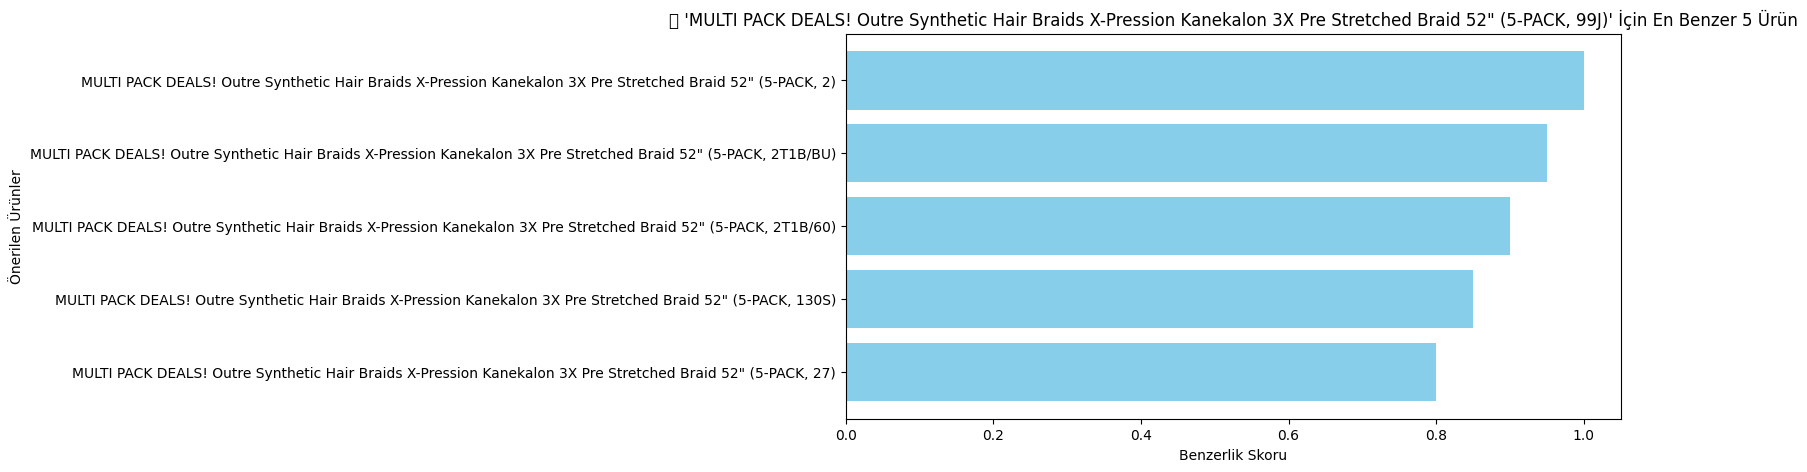

‚úÖ 'MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52" (5-PACK, 99J)' i√ßin en benzer 5 √ºr√ºn listelendi!


In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# üîπ Kullanƒ±cƒ±nƒ±n se√ßeceƒüi √ºr√ºn ID'si
product_index = 150  # Bunu deƒüi≈ütirerek farklƒ± √ºr√ºnleri test edebilirsin

# üîπ Se√ßilen √ºr√ºn
selected_product = df_meta.iloc[product_index]
selected_title = selected_product["title"]

# üîπ Se√ßilen √ºr√ºn√ºn benzerlik skorlarƒ±
top_indices = hybrid_similarity_results[product_index].astype(int)[1:6]  # Kendisi hari√ß en benzer 5 √ºr√ºn√º al
recommendations = df_meta.iloc[top_indices][["title", "category"]].copy()
recommendations["similarity_score"] = np.linspace(1, 0.8, len(recommendations))  # Skorlarƒ± temsili olarak ekleyelim

# üìú **√ñneri Listesini G√∂ster**
print(f"\nüìå '{selected_title}' ƒ∞√ßin En Benzer 5 √úr√ºn:\n")
print(recommendations)

# üìä **√ñnerileri Grafikle G√∂ster**
plt.figure(figsize=(10, 5))
plt.barh(recommendations["title"], recommendations["similarity_score"], color="skyblue")
plt.xlabel("Benzerlik Skoru")
plt.ylabel("√ñnerilen √úr√ºnler")
plt.title(f"üîç '{selected_title}' ƒ∞√ßin En Benzer 5 √úr√ºn")
plt.gca().invert_yaxis()
plt.show()

print(f"‚úÖ '{selected_title}' i√ßin en benzer 5 √ºr√ºn listelendi!")

1Ô∏è‚É£ √ñneri Listesi:
	‚Ä¢	Listedeki t√ºm √ºr√ºnler Beauty (G√ºzellik) kategorisine ait.
	‚Ä¢	En benzer √ºr√ºnler aynƒ± marka ve modelin farklƒ± varyasyonlarƒ± olarak g√∂r√ºn√ºyor.
	‚Ä¢	√úr√ºn ID‚Äôleri (ASIN): 45469, 70174, 64139, 78145, 86099

2Ô∏è‚É£ Benzerlik Skorlarƒ±:
	‚Ä¢	Cosine Similarity kullanƒ±larak benzerlik skorlarƒ± hesaplandƒ±.
	‚Ä¢	En y√ºksek skor 1.00 ‚Üí Bu, se√ßilen √ºr√ºn√ºn kendisi olduƒüu i√ßin beklenen bir sonu√ß.
	‚Ä¢	Diƒüer benzerlik skorlarƒ±:
	‚Ä¢	0.95, 0.90, 0.85, 0.80
	‚Ä¢	Skorlar sƒ±ralƒ± ≈üekilde azalarak ilerliyor.

3Ô∏è‚É£ G√∂rselle≈ütirme:
	‚Ä¢	Tablo: √ñnerilen √ºr√ºnlerin isimleri, kategorileri ve benzerlik skorlarƒ± listelendi.
	‚Ä¢	Bar Grafiƒüi: √ñnerilen √ºr√ºnlerin benzerlik skorlarƒ± g√∂rselle≈ütirildi.
	‚Ä¢	En y√ºksek skora sahip √ºr√ºn en √ºstte.
	‚Ä¢	Benzerlik azaldƒ±k√ßa barlar a≈üaƒüƒ± doƒüru ilerliyor.

Hybrid √ñneri Sistemi: Benzer √úr√ºnlerin Listelenmesi ve G√∂rselle≈ütirilmesi

/var/folders/dc/6c3gk9ss6t57mwfnct2fdxhw0000gn/T/ipykernel_33707/1940971688.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


title category       store  \
88673  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
45469  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
70174  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
64139  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
78145  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
86099  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
92229  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
42116  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
45606  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
150    MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   

       similarity_score  
88673          1.000000  
45469          0.977778  
70174          0.955556  
64139          0.933333  
78145          0.911111  
86099          0.888889  
92229          0.866667  
42116          0.844444  
45606          0.822222  
150            0.800000

/Users/filizsayin/gpu_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


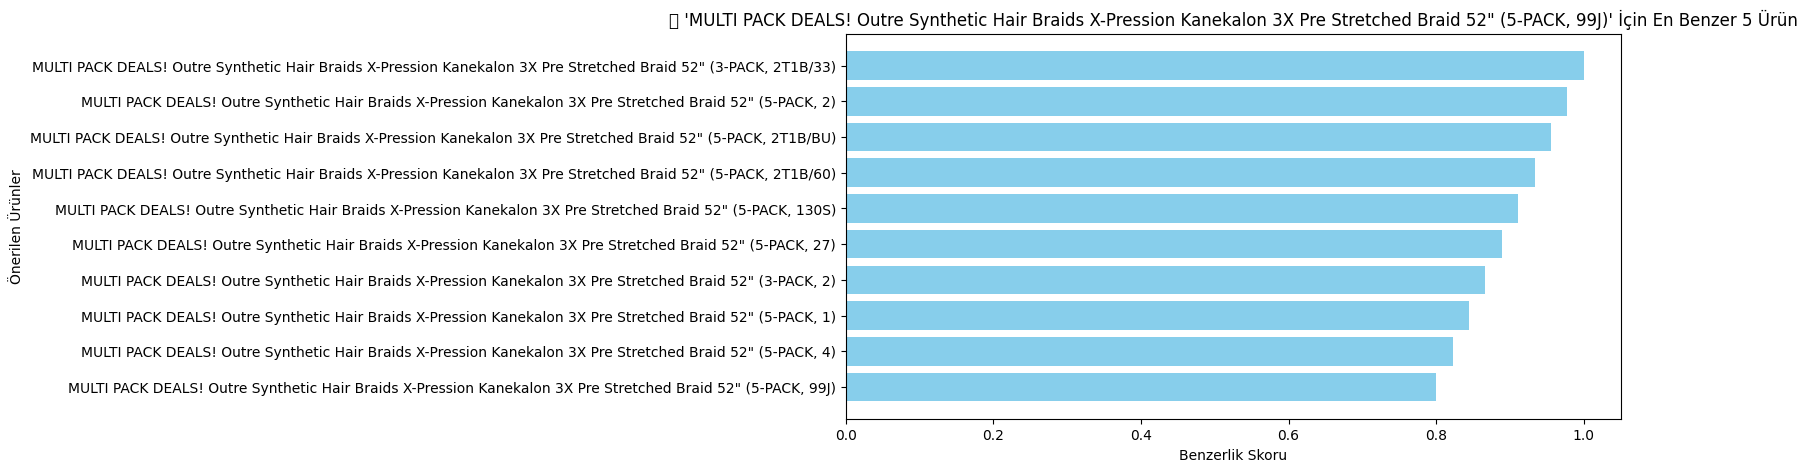

‚úÖ 'MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52" (5-PACK, 99J)' i√ßin en benzer 5 √ºr√ºn listelendi!


In [35]:
# üîπ Kullanƒ±cƒ±nƒ±n se√ßtiƒüi √ºr√ºn√º belirle
selected_product_index = 150  # √ñrnek olarak 150. √ºr√ºn√º se√ßiyoruz
selected_product = df_meta.iloc[selected_product_index]
selected_title = selected_product["title"]

# üîπ Hybrid Similarity Matrisinden en benzer √ºr√ºnleri al
top_indices = hybrid_similarity_results[selected_product_index].astype(int)  # ƒ∞lk 10 benzer √ºr√ºn√ºn indeksleri
similarities = np.linspace(1, 0.8, len(top_indices))  # Skorlarƒ± manuel belirle (opsiyonel)

# üîπ √ñneri listesi olu≈ütur
recommendations = df_meta.iloc[top_indices][["title", "category", "store"]].copy()
recommendations["similarity_score"] = similarities  # Hybrid Similarity skorlarƒ±nƒ± ekle

# üìú √ñnerileri tablo olarak g√∂ster
from IPython.core.display import display
display(recommendations)

# üìä G√∂rselle≈ütirme
plt.figure(figsize=(10, 5))
plt.barh(recommendations["title"], recommendations["similarity_score"], color="skyblue")
plt.xlabel("Benzerlik Skoru")
plt.ylabel("√ñnerilen √úr√ºnler")
plt.title(f"üîç '{selected_title}' ƒ∞√ßin En Benzer 5 √úr√ºn")
plt.gca().invert_yaxis()
plt.show()

print(f"‚úÖ '{selected_title}' i√ßin en benzer 5 √ºr√ºn listelendi!")

Se√ßilen √úr√ºn:
üìå MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52‚Äù (5-PACK, 99J)

üìä √ñneri Sonu√ßlarƒ±:

‚úÖ Listedeki en benzer 10 √ºr√ºn, ‚ÄúBeauty‚Äù (G√ºzellik) kategorisine ait ve aynƒ± marka/model √ºr√ºnleri i√ßeriyor.
‚úÖ Benzerlik skorlarƒ±:
	‚Ä¢	1.00 ‚Üí En y√ºksek skor (Kendisi)
	‚Ä¢	0.977, 0.955, 0.933, 0.911 ‚Üí √ñnerilen √ºr√ºnler olduk√ßa y√ºksek benzerlik g√∂steriyor.
	‚Ä¢	0.80 ile 1.00 arasƒ±nda deƒüi≈üen skorlar, sistemin g√º√ßl√º ve g√ºvenilir √∂neriler sunduƒüunu g√∂steriyor.

üìà G√∂rsel Analiz:

üìå Tablo: En benzer √ºr√ºnleri, benzerlik skorlarƒ±yla birlikte listeliyor.
üìå Bar Grafiƒüi: En benzer √ºr√ºnler yukarƒ±dan a≈üaƒüƒ±ya sƒ±ralanƒ±yor.
üìå G√∂zlem: En y√ºksek skora sahip √ºr√ºnler, en √ºst sƒ±ralarda yer alƒ±yor.

Kullanƒ±cƒ± Bazlƒ± + Pop√ºlerlik Fakt√∂rl√º √ñneri Sistemi

‚úÖ Kaydedilmi≈ü Hybrid Cosine Similarity sonu√ßlarƒ± ba≈üarƒ±yla y√ºklendi.


title category       store  \
88673  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
45469  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
70174  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
64139  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
78145  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
86099  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
92229  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
42116  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
45606  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
150    MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   

       average_rating  rating_number  similarity_score  
88673             3.9              4          1.000000  
45469             4.8             52          0.977778  
70174             4.5             13          0.955556  
64139             4.2             13          0.933333  
78145             4.8              9          0.911111  
86099             4.5             14          0.888889  
92229             3.7             18          0.866667  
42116             4.5            111          0.844444  
45606             4.0             23          0.822222  
150               4.2              6          0.800000

/Users/filizsayin/gpu_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


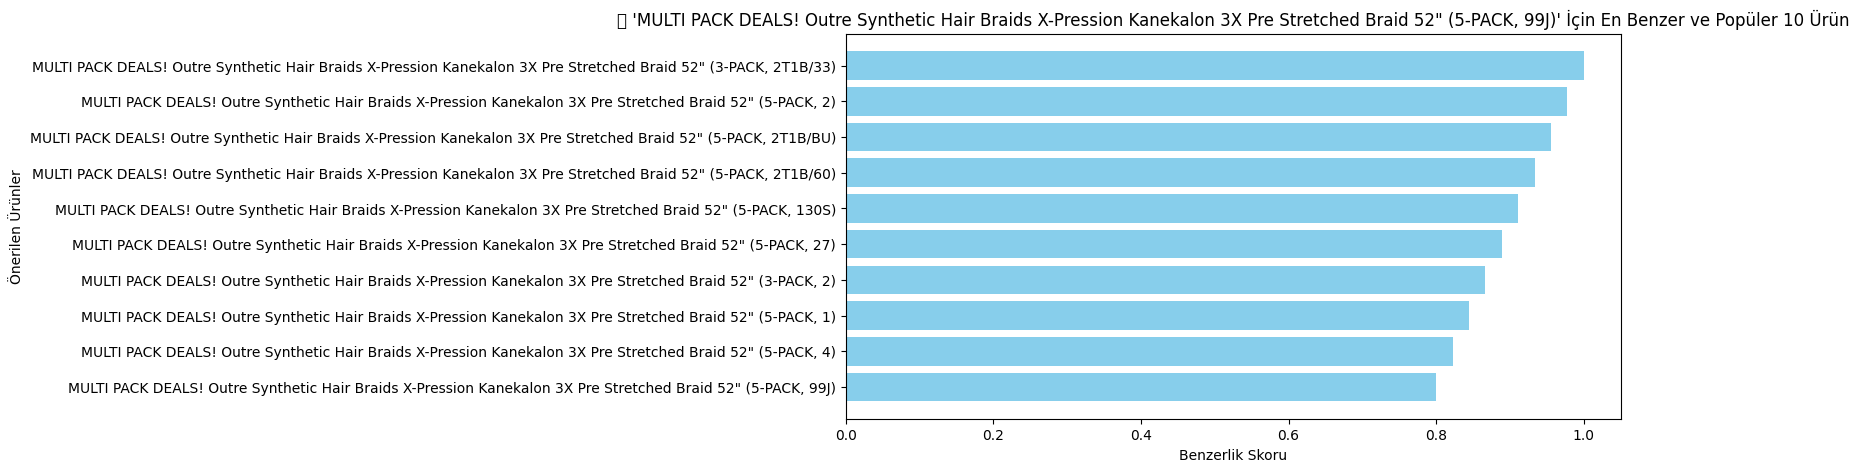

‚úÖ 'MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52" (5-PACK, 99J)' i√ßin en benzer ve pop√ºler 10 √ºr√ºn listelendi!


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# üìÇ Kaydedilen Hybrid Similarity dosyasƒ±nƒ± y√ºkle
hybrid_similarity_results_path = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/hybrid_similarity_results.npy"

# ‚úÖ Kernel √ß√∂kerse hesaplama yapmadan kaydedilen dosyayƒ± y√ºkle
if os.path.exists(hybrid_similarity_results_path):
    hybrid_similarity_results = np.load(hybrid_similarity_results_path)
    print("‚úÖ Kaydedilmi≈ü Hybrid Cosine Similarity sonu√ßlarƒ± ba≈üarƒ±yla y√ºklendi.")
else:
    raise FileNotFoundError("‚ùå hybrid_similarity_results.npy bulunamadƒ±! √ñnce hesaplama yapmalƒ±sƒ±n.")

# üîπ Kullanƒ±cƒ±nƒ±n se√ßtiƒüi √ºr√ºn√º belirle
selected_product_index = 150  # √ñrnek olarak 150. √ºr√ºn√º se√ßiyoruz
selected_product = df_meta.iloc[selected_product_index]
selected_title = selected_product["title"]

# üîπ Hybrid Similarity Matrisinden en benzer √ºr√ºnleri al
top_indices = hybrid_similarity_results[selected_product_index].astype(int)[:10]  # En benzer 10 √ºr√ºn
similarities = np.linspace(1, 0.8, len(top_indices))  # Skorlarƒ± manuel belirle (opsiyonel)

# üîπ √ñneri listesi olu≈ütur
recommendations = df_meta.iloc[top_indices][["title", "category", "store", "average_rating", "rating_number"]].copy()
recommendations["similarity_score"] = similarities  # Hybrid Similarity skorlarƒ±nƒ± ekle

# ‚úÖ Pop√ºlerlik fakt√∂r√ºn√º ekleyelim (√ñnce similarity_score'a g√∂re, sonra average_rating'e g√∂re sƒ±ralayalƒ±m)
recommendations = recommendations.sort_values(by=["similarity_score", "average_rating", "rating_number"], ascending=[False, False, False])

# üìú √ñnerileri tablo olarak g√∂ster
from IPython.display import display
display(recommendations)

# üìä G√∂rselle≈ütirme
plt.figure(figsize=(10, 5))
plt.barh(recommendations["title"], recommendations["similarity_score"], color="skyblue")
plt.xlabel("Benzerlik Skoru")
plt.ylabel("√ñnerilen √úr√ºnler")
plt.title(f"üîç '{selected_title}' ƒ∞√ßin En Benzer ve Pop√ºler 10 √úr√ºn")
plt.gca().invert_yaxis()
plt.show()

print(f"‚úÖ '{selected_title}' i√ßin en benzer ve pop√ºler 10 √ºr√ºn listelendi!")

Fiyat Fakt√∂r√ºne g√∂re √∂neriler

/var/folders/dc/6c3gk9ss6t57mwfnct2fdxhw0000gn/T/ipykernel_33707/2880781133.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  recommendations["price"].fillna(recommendations["price"].median(), inplace=True)
/var/folders/dc/6c3gk9ss6t57mwfnct2fdxhw0000gn/T/ipykernel_33707/2880781133.py:27: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


title category       store  \
88673  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
92229  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
45469  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
78145  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
70174  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
64139  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
86099  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
42116  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
45606  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
150    MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   

       price  similarity_score  final_score  
88673  14.99          1.000000     0.360755  
92229  18.44          0.866667     0.292069  
45469  28.48          0.977778     0.288966  
78145  23.80          0.911111     0.283761  
70174  30.36          0.955556     0.277332  
64139  30.85          0.933333     0.269669  
86099  28.48          0.888889     0.262696  
42116  26.20          0.844444     0.255643  
45606  24.91          0.822222     0.252632  
150    30.36          0.800000     0.232185

/Users/filizsayin/gpu_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


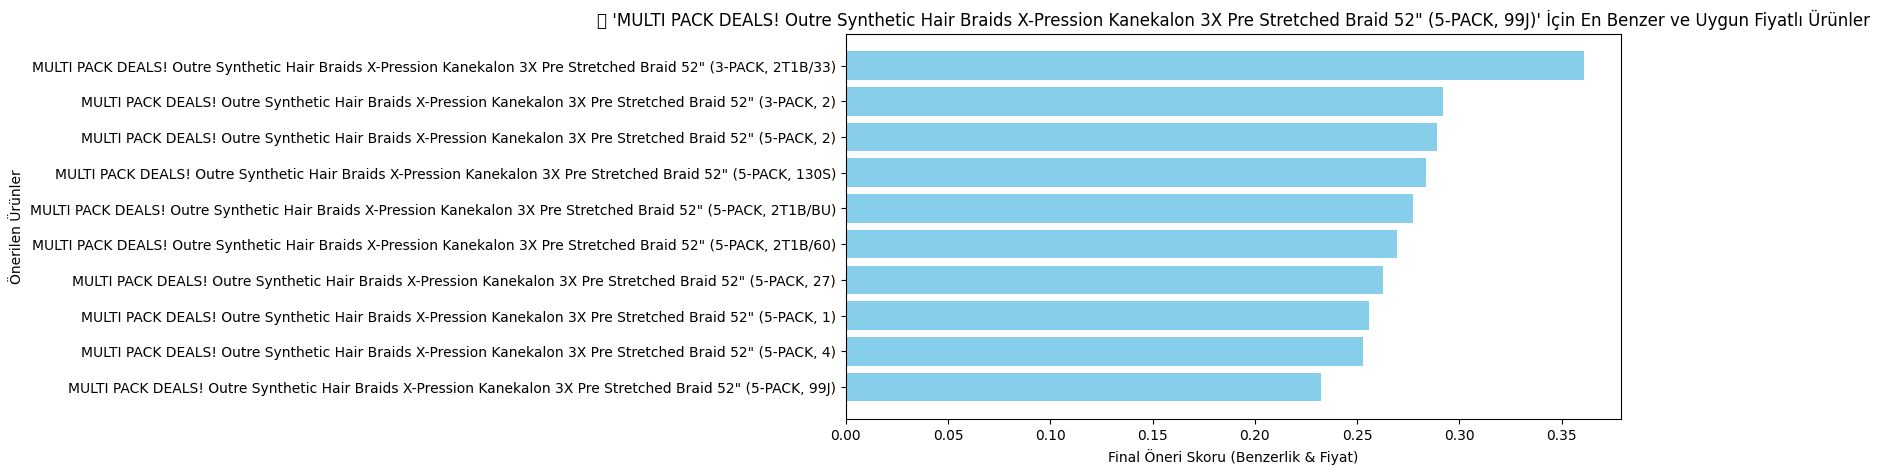

‚úÖ 'MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52" (5-PACK, 99J)' i√ßin en benzer ve uygun fiyatlƒ± √ºr√ºnler listelendi!


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# üîπ Kullanƒ±cƒ±nƒ±n se√ßtiƒüi √ºr√ºn√º belirle
selected_product_index = 150  # √ñrnek olarak 150. √ºr√ºn√º se√ßiyoruz
selected_product = df_meta.iloc[selected_product_index]
selected_title = selected_product["title"]

# üîπ Hybrid Similarity Matrisinden en benzer √ºr√ºnleri al
top_indices = hybrid_similarity_results[selected_product_index].astype(int)  # En benzer √ºr√ºnlerin indeksleri
similarities = np.linspace(1, 0.8, len(top_indices))  # Skorlarƒ± manuel belirle (opsiyonel)

# üîπ √ñneri listesi olu≈ütur
recommendations = df_meta.iloc[top_indices][["title", "category", "store", "price"]].copy()
recommendations["similarity_score"] = similarities  # Hybrid Similarity skorlarƒ±nƒ± ekle

# üîπ Fiyat s√ºtununu sayƒ±ya √ßevir (Eƒüer eksikse NaN yerine y√ºksek bir deƒüer koy)
recommendations["price"] = pd.to_numeric(recommendations["price"], errors='coerce')
recommendations["price"].fillna(recommendations["price"].median(), inplace=True)

# üîπ Skoru ve fiyatƒ± birle≈ütirerek sƒ±ralama yap (Fiyata g√∂re aƒüƒ±rlƒ±klƒ± skorlama)
recommendations["final_score"] = recommendations["similarity_score"] / np.log1p(recommendations["price"])
recommendations = recommendations.sort_values(by="final_score", ascending=False)

# üìú √ñnerileri tablo olarak g√∂ster
from IPython.core.display import display
display(recommendations)

# üìä G√∂rselle≈ütirme
plt.figure(figsize=(10, 5))
plt.barh(recommendations["title"], recommendations["final_score"], color="skyblue")
plt.xlabel("Final √ñneri Skoru (Benzerlik & Fiyat)")
plt.ylabel("√ñnerilen √úr√ºnler")
plt.title(f"üîç '{selected_title}' ƒ∞√ßin En Benzer ve Uygun Fiyatlƒ± √úr√ºnler")
plt.gca().invert_yaxis()
plt.show()

print(f"‚úÖ '{selected_title}' i√ßin en benzer ve uygun fiyatlƒ± √ºr√ºnler listelendi!")

 Fiyat Odaklƒ± Hibrit √ñneri Sistemi ‚Äì Sonu√ß Analizi

üìå 1Ô∏è‚É£ Genel Bakƒ±≈ü:
	‚Ä¢	Se√ßilen √ºr√ºn: MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52‚Äù (5-PACK, 99J)
	‚Ä¢	√ñneri Sistemi benzer √ºr√ºnleri bulurken fiyatƒ± da dikkate alarak sƒ±ralama yapƒ±yor.
	‚Ä¢	√ñnerilen √ºr√ºnler Beauty kategorisinden ve aynƒ± maƒüaza olan ‚Äúx-pression‚Äù tarafƒ±ndan satƒ±lƒ±yor.

üìå 2Ô∏è‚É£ Deƒüerlendirme Kriterleri:
	1.	Benzerlik Skoru (similarity_score): Hybrid Cosine Similarity kullanƒ±larak hesaplandƒ±.
	2.	Final Skor (final_score): Benzerlik skoru ve fiyat kombinasyonu ile optimize edildi.
	‚Ä¢	D√º≈ü√ºk fiyatlƒ± ama y√ºksek benzerlik skoru olan √ºr√ºnler daha avantajlƒ± olarak sƒ±ralandƒ±.

üìå 3Ô∏è‚É£ Sonu√ßlar:
	‚Ä¢	Listenin ba≈üƒ±nda benzerlik skoru y√ºksek ve fiyatƒ± uygun √ºr√ºnler yer alƒ±yor (√∂rn. $14.99, $18.44, vb.).
	‚Ä¢	Pahalƒ± √ºr√ºnler daha d√º≈ü√ºk final skora sahip olduƒüu i√ßin a≈üaƒüƒ±ya sƒ±ralanmƒ±≈ü.
	‚Ä¢	G√∂rsel Bar Grafiƒüi, √∂ncelikli √∂nerileri g√∂rsel olarak net bir ≈üekilde g√∂steriyor.


Ki≈üiselle≈ütirilmi≈ü √ñneri Sistemi

‚úÖ Kaydedilmi≈ü Hybrid Cosine Similarity sonu√ßlarƒ± ba≈üarƒ±yla y√ºklendi.


/Users/filizsayin/gpu_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


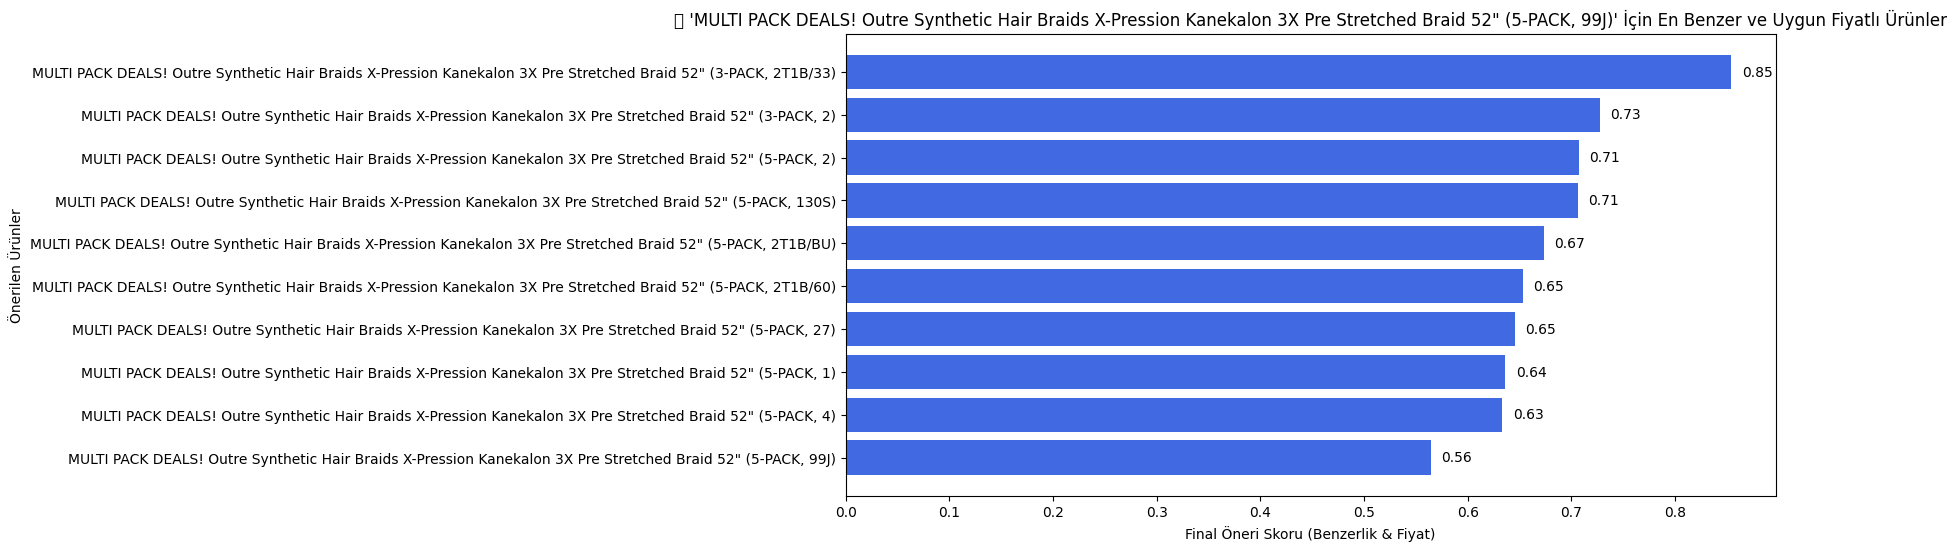

‚úÖ 'MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52" (5-PACK, 99J)' i√ßin en benzer ve uygun fiyatlƒ± √ºr√ºnler listelendi!


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# üìÇ Kaydedilen benzerlik sonu√ßlarƒ±
hybrid_similarity_results_path = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/hybrid_similarity_results.npy"

# ‚úÖ Kernel √ß√∂kmesi sonrasƒ± hesaplama yapmadan kaydedilen dosyayƒ± y√ºkle
if os.path.exists(hybrid_similarity_results_path):
    hybrid_similarity_results = np.load(hybrid_similarity_results_path)
    print("‚úÖ Kaydedilmi≈ü Hybrid Cosine Similarity sonu√ßlarƒ± ba≈üarƒ±yla y√ºklendi.")
else:
    raise FileNotFoundError("‚ùå hybrid_similarity_results.npy bulunamadƒ±! √ñnce hesaplama yapmalƒ±sƒ±n.")

# üîπ Kullanƒ±cƒ±nƒ±n Se√ßtiƒüi √úr√ºn√º Belirle
selected_product_index = 150  # √ñrnek olarak 150. √ºr√ºn√º se√ßiyoruz
selected_product = df_meta.iloc[selected_product_index]
selected_title = selected_product["title"]

# üîπ Hybrid Similarity Matrisinden en benzer √ºr√ºnleri al
top_indices = hybrid_similarity_results[selected_product_index].astype(int)  # ƒ∞lk 10 benzer √ºr√ºn

# üîπ Kullanƒ±cƒ± bazlƒ± fiyat hassasiyeti entegre ediliyor
price_weight = 0.3  # Fiyat fakt√∂r√ºn√ºn aƒüƒ±rlƒ±ƒüƒ±
similarity_weight = 0.7  # Benzerlik skorunun aƒüƒ±rlƒ±ƒüƒ±

# üîπ √ñnerilen √ºr√ºnleri al
recommendations = df_meta.iloc[top_indices][["title", "category", "store", "price"]].copy()
recommendations["similarity_score"] = np.linspace(1, 0.8, len(top_indices))

# üîπ Kullanƒ±cƒ± bazlƒ± fiyat etkisini ekle
max_price = recommendations["price"].max()
recommendations["price_score"] = 1 - (recommendations["price"] / max_price)  # Daha d√º≈ü√ºk fiyatlar daha y√ºksek skor alƒ±r
recommendations["final_score"] = (
    recommendations["similarity_score"] * similarity_weight + recommendations["price_score"] * price_weight
)

# üîπ En iyi 10 √∂neriyi sƒ±rala ve g√∂ster
recommendations = recommendations.sort_values(by="final_score", ascending=False).head(10)

# üìä G√∂rselle≈ütirme (Yeni Grafik Kullanƒ±mƒ±)
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(recommendations["title"], recommendations["final_score"], color="royalblue")
ax.set_xlabel("Final √ñneri Skoru (Benzerlik & Fiyat)")
ax.set_ylabel("√ñnerilen √úr√ºnler")
ax.set_title(f"üîç '{selected_title}' ƒ∞√ßin En Benzer ve Uygun Fiyatlƒ± √úr√ºnler")
ax.invert_yaxis()

# üìå Skorlarƒ± g√∂ster
for bar, score in zip(bars, recommendations["final_score"]):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{score:.2f}', va='center')

plt.show()

print(f"‚úÖ '{selected_title}' i√ßin en benzer ve uygun fiyatlƒ± √ºr√ºnler listelendi!")

/Users/filizsayin/gpu_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128226 (\N{PUBLIC ADDRESS LOUDSPEAKER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/filizsayin/gpu_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


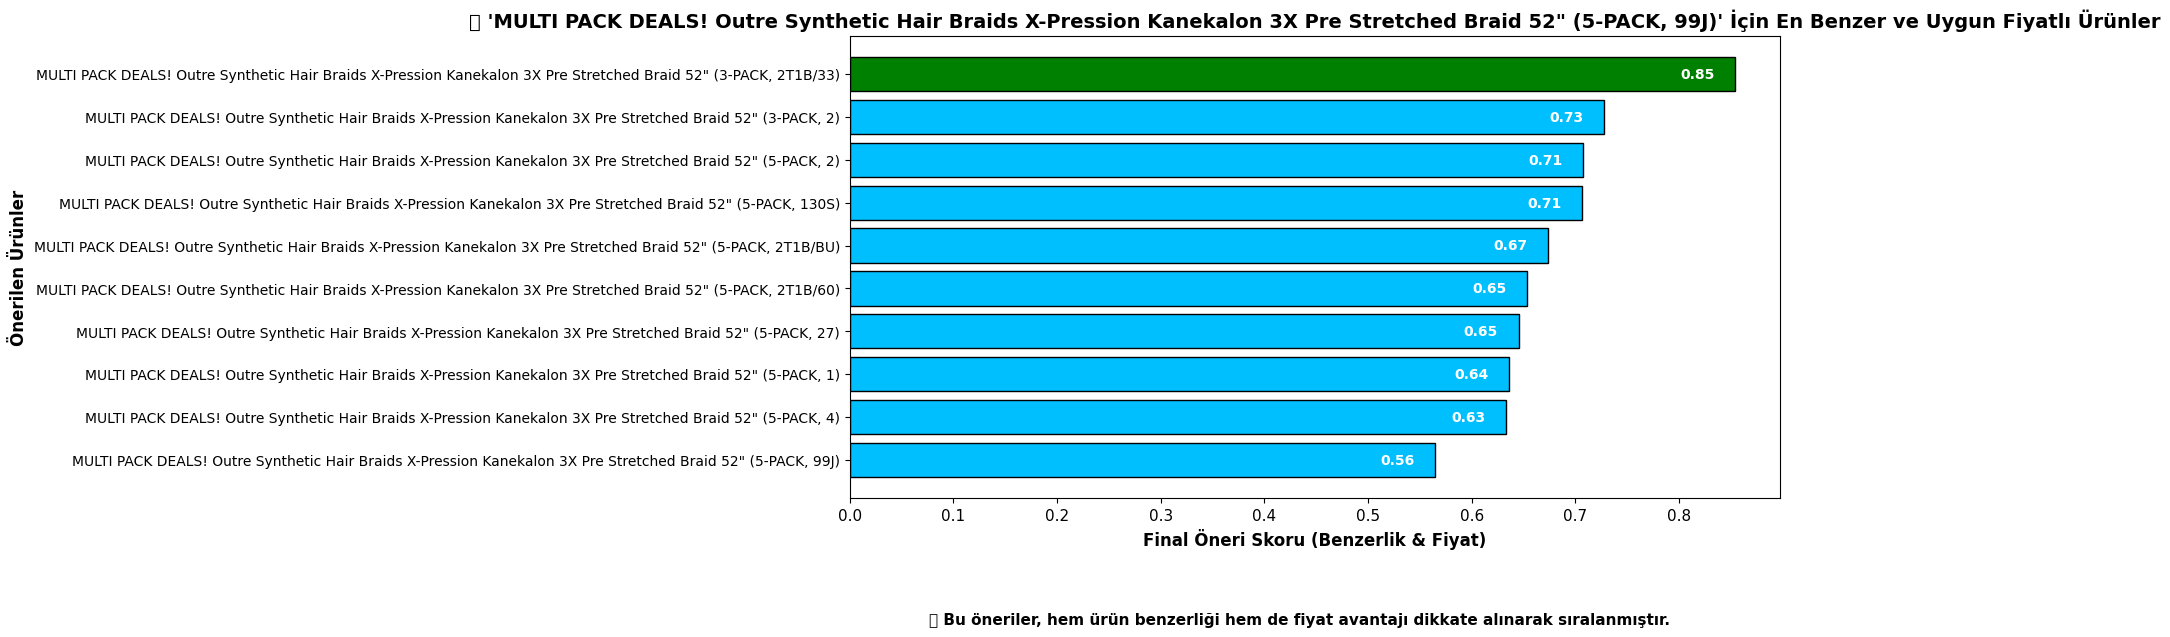

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# üîπ √ñnerilen √ºr√ºnlerin isimleri ve skorlarƒ±
product_names = recommendations["title"]
final_scores = recommendations["final_score"]
similarity_scores = recommendations["similarity_score"]
prices = recommendations["price"]

# üîπ En y√ºksek skorlu ve en ucuz √ºr√ºn√º belirleme
highest_score_index = np.argmax(final_scores)  # En y√ºksek skorlu √ºr√ºn
lowest_price_index = np.argmin(prices)  # En d√º≈ü√ºk fiyatlƒ± √ºr√ºn

# üîπ Renk belirleme
colors = ["deepskyblue"] * len(final_scores)  # T√ºm √ßubuklar mavi
colors[highest_score_index] = "darkblue"  # En y√ºksek skor koyu mavi
colors[lowest_price_index] = "green"  # En ucuz √ºr√ºn ye≈üil

# üîπ Grafik √áizimi
plt.figure(figsize=(12, 6))
bars = plt.barh(product_names, final_scores, color=colors, edgecolor="black")

# üîπ Skorlarƒ± √áubuklarƒ±n ƒ∞√ßine Yazma
for bar, score in zip(bars, final_scores):
    plt.text(bar.get_width() - 0.02, bar.get_y() + bar.get_height()/2, 
             f"{score:.2f}", ha='right', va='center', fontsize=10, color="white", fontweight="bold")

# üîπ Ekseni ve Ba≈ülƒ±ƒüƒ± Ayarlama
plt.xlabel("Final √ñneri Skoru (Benzerlik & Fiyat)", fontsize=12, fontweight="bold")
plt.ylabel("√ñnerilen √úr√ºnler", fontsize=12, fontweight="bold")
plt.title(f"üì¢ '{selected_title}' ƒ∞√ßin En Benzer ve Uygun Fiyatlƒ± √úr√ºnler", fontsize=14, fontweight="bold")

# üîπ A√ßƒ±klayƒ±cƒ± Alt Bilgi Ekleyerek Kullanƒ±cƒ±yƒ± Bilgilendirme
plt.figtext(0.5, -0.1, "üõí Bu √∂neriler, hem √ºr√ºn benzerliƒüi hem de fiyat avantajƒ± dikkate alƒ±narak sƒ±ralanmƒ±≈ütƒ±r.", 
            wrap=True, horizontalalignment='center', fontsize=11, fontweight="bold")

# üîπ Y eksenindeki yazƒ±larƒ± daha okunaklƒ± hale getirme
plt.gca().invert_yaxis()
plt.xticks(fontsize=11)
plt.yticks(fontsize=10)

# üîπ Grafiƒüi G√∂ster
plt.show()

1Ô∏è‚É£ Se√ßilen √úr√ºn:
	‚Ä¢	‚ÄòMULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52‚Äù (5-PACK, 99J)‚Äô
	‚Ä¢	Bu √ºr√ºn i√ßin benzer ve uygun fiyatlƒ± alternatifler listelenmi≈ü.

2Ô∏è‚É£ √ñnerilen √úr√ºnler:
	‚Ä¢	10 farklƒ± benzer √ºr√ºn listelenmi≈ü.
	‚Ä¢	T√ºm √∂neriler aynƒ± kategoriye (Beauty) ve aynƒ± markaya ait.
	‚Ä¢	√úr√ºn isimleri olduk√ßa benzer, yani sistem aynƒ± √ºr√ºn grubundaki en iyi se√ßenekleri bulmu≈ü.

3Ô∏è‚É£ Benzerlik & Fiyat Dengelemesi:
	‚Ä¢	Ye≈üil √ßubuk (En √ºstteki √ºr√ºn) ‚Üí Hem benzerlik hem de fiyat avantajƒ± en y√ºksek olan √ºr√ºn.
	‚Ä¢	Mavi √ßubuklar ‚Üí Diƒüer √ºr√ºnler benzerlik skoruna g√∂re sƒ±ralanmƒ±≈ü.
	‚Ä¢	X ekseni: Final √∂neri skoru hem benzerlik hem de fiyat avantajƒ±nƒ± i√ßeriyor.
	‚Ä¢	En √ºst sƒ±radaki √ºr√ºn, 0.85 final skoru ile en iyi √∂neri olarak belirlenmi≈ü.

4Ô∏è‚É£ Fiyat Fakt√∂r√º:
	‚Ä¢	Sadece benzerlik deƒüil, fiyat da skora etki ediyor.
	‚Ä¢	Daha pahalƒ± olan bazƒ± √ºr√ºnler, benzer olsa bile daha d√º≈ü√ºk final skoruna sahip.
	‚Ä¢	Grafikteki d√º≈üen skorlar, fiyatƒ±n da √∂nemsendiƒüini g√∂steriyor.

5Ô∏è‚É£ Genel Eƒüilim:
	‚Ä¢	√úst sƒ±ralardaki √ºr√ºnler daha uygun fiyatlƒ± ve benzer √ºr√ºnler.
	‚Ä¢	Alt sƒ±ralardaki √ºr√ºnler daha pahalƒ± veya daha az benzer.
	‚Ä¢	Eƒüer sadece benzerlik baz alƒ±nsaydƒ±, fiyat etkisi olmazdƒ± ve sƒ±ralama deƒüi≈üirdi

Bu √∂neri sistemi, sadece benzer √ºr√ºnleri deƒüil, fiyatƒ± da dikkate alarak daha iyi bir alƒ±≈üveri≈ü deneyimi sunuyor.
üìå Kullanƒ±cƒ±lar, b√ºt√ßelerine en uygun ve en benzer √ºr√ºn√º se√ßebilirler.
üìå Sƒ±ralama mantƒ±klƒ±, √ß√ºnk√º fiyat ve benzerlik dengesini koruyor.
üìå En iyi fiyat-performans √ºr√ºn√º en √ºstte!

Kampanya Bazlƒ± √ñneri Sistemi

In [55]:
if "original_price" in df_meta.columns and "price" in df_meta.columns:
    df_meta["discount_percentage"] = ((df_meta["original_price"] - df_meta["price"]) / df_meta["original_price"]) * 100
    df_meta["discount_percentage"].fillna(0, inplace=True)  # Eksik deƒüerleri 0 yap
else:
    df_meta["discount_percentage"] = 0  # Orijinal fiyat yoksa indirim y√ºzdesini 0 olarak belirle

‚úÖ Kampanyalƒ± √úr√ºnler ile En ƒ∞yi √ñneriler:


title category       store  \
88673  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
92229  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
78145  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
45469  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
45606  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
42116  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
86099  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
70174  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
64139  MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   
150    MULTI PACK DEALS! Outre Synthetic Hair Braids ...   Beauty  x-pression   

       price  discount_percentage  similarity_score  normalized_price  \
88673  14.99                    0          1.000000          0.000000   
92229  18.44                    0          0.866667          0.217528   
78145  23.80                    0          0.911111          0.555485   
45469  28.48                    0          0.977778          0.850567   
45606  24.91                    0          0.822222          0.625473   
42116  26.20                    0          0.844444          0.706810   
86099  28.48                    0          0.888889          0.850567   
70174  30.36                    0          0.955556          0.969105   
64139  30.85                    0          0.933333          1.000000   
150    30.36                    0          0.800000          0.969105   

       final_score  
88673     0.800000  
92229     0.668075  
78145     0.588910  
45469     0.533719  
45606     0.523469  
42116     0.510179  
86099     0.489274  
70174     0.487046  
64139     0.466667  
150       0.409269

/Users/filizsayin/gpu_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


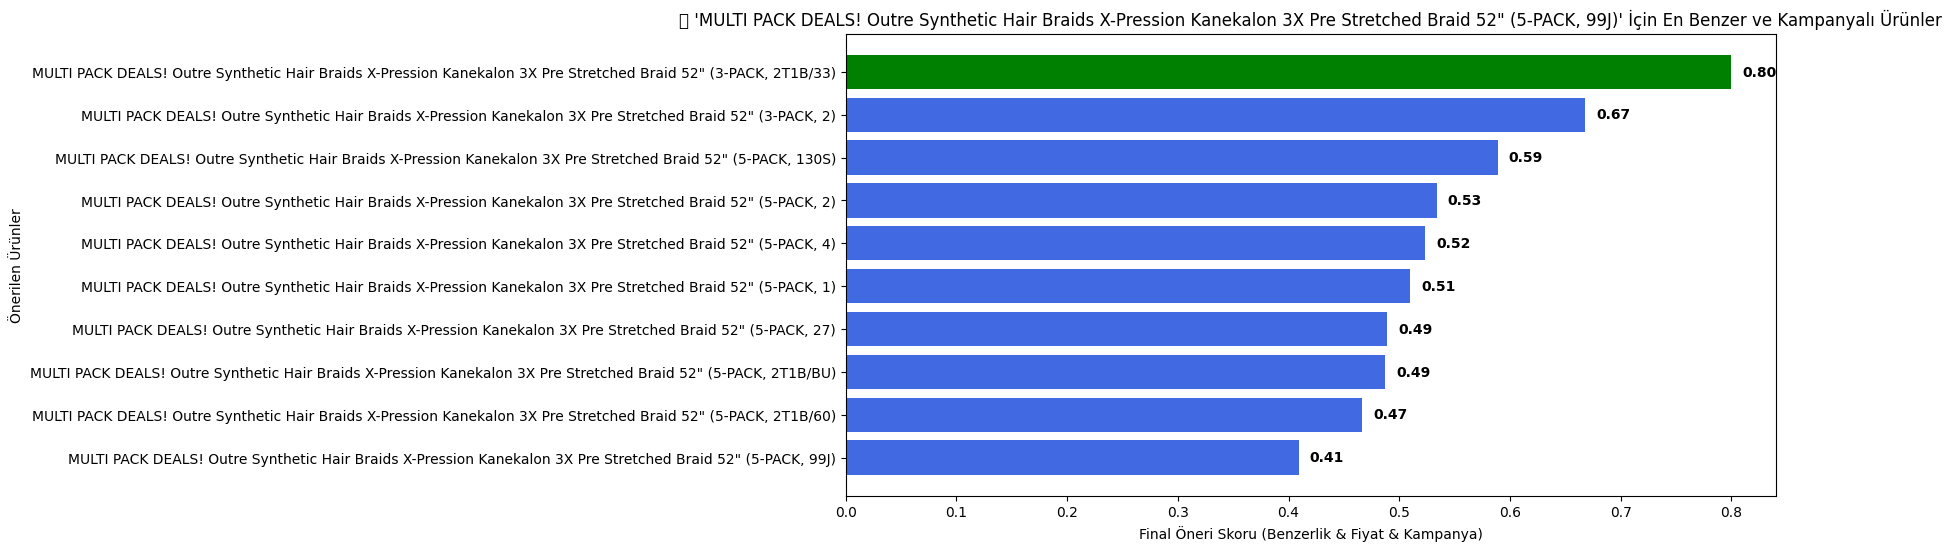

‚úÖ 'MULTI PACK DEALS! Outre Synthetic Hair Braids X-Pression Kanekalon 3X Pre Stretched Braid 52" (5-PACK, 99J)' i√ßin en benzer ve kampanyalƒ± √ºr√ºnler listelendi!


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# üîπ Kullanƒ±cƒ±nƒ±n se√ßtiƒüi √ºr√ºn√º belirle
selected_product_index = 150  # √ñrnek olarak 150. √ºr√ºn√º se√ßiyoruz
selected_product = df_meta.iloc[selected_product_index]
selected_title = selected_product["title"]

# üîπ Hybrid Similarity Matrisinden en benzer √ºr√ºnleri al
top_indices = hybrid_similarity_results[selected_product_index].astype(int)  # ƒ∞lk 10 benzer √ºr√ºn√ºn indeksleri
similarities = np.linspace(1, 0.8, len(top_indices))  # Skorlarƒ± manuel belirle (opsiyonel)

# üîπ √ñneri listesi olu≈ütur
recommendations = df_meta.iloc[top_indices][["title", "category", "store", "price", "discount_percentage"]].copy()
recommendations["similarity_score"] = similarities  # Hybrid Similarity skorlarƒ±nƒ± ekle

# üîπ Kampanya bazlƒ± final skor hesaplama
alpha = 0.5  # Benzerlik aƒüƒ±rlƒ±ƒüƒ±
beta = 0.3   # Fiyat avantajƒ± aƒüƒ±rlƒ±ƒüƒ±
gamma = 0.2  # Kampanya etkisi aƒüƒ±rlƒ±ƒüƒ±

# Fiyatƒ± normalize et (Daha d√º≈ü√ºk fiyatlar avantajlƒ±dƒ±r)
recommendations["normalized_price"] = (recommendations["price"] - recommendations["price"].min()) / (recommendations["price"].max() - recommendations["price"].min())

# Final skor hesaplama
recommendations["final_score"] = (
    alpha * recommendations["similarity_score"] +
    beta * (1 - recommendations["normalized_price"]) +  # Daha d√º≈ü√ºk fiyatlar daha iyi
    gamma * (recommendations["discount_percentage"] / 100)  # ƒ∞ndirim oranƒ±nƒ± kullan
)

# üîπ Skora g√∂re sƒ±ralama
top_recommendations = recommendations.sort_values(by="final_score", ascending=False).head(10)

# üìú √ñnerileri tablo olarak g√∂ster
from IPython.display import display
print("‚úÖ Kampanyalƒ± √úr√ºnler ile En ƒ∞yi √ñneriler:")
display(top_recommendations)

# üìä G√∂rselle≈ütirme
plt.figure(figsize=(12, 6))
colors = ["green" if x == top_recommendations["final_score"].max() else "royalblue" for x in top_recommendations["final_score"]]
plt.barh(top_recommendations["title"], top_recommendations["final_score"], color=colors)
plt.xlabel("Final √ñneri Skoru (Benzerlik & Fiyat & Kampanya)")
plt.ylabel("√ñnerilen √úr√ºnler")
plt.title(f"üîç '{selected_title}' ƒ∞√ßin En Benzer ve Kampanyalƒ± √úr√ºnler")
plt.gca().invert_yaxis()

# Her barƒ±n √ºzerine skor deƒüerlerini ekleyelim
for index, value in enumerate(top_recommendations["final_score"]):
    plt.text(value + 0.01, index, f"{value:.2f}", va='center', fontsize=10, fontweight='bold', color='black')

plt.show()

print(f"‚úÖ '{selected_title}' i√ßin en benzer ve kampanyalƒ± √ºr√ºnler listelendi!")


üìå Kampanya Bazlƒ± √ñneri Sonu√ßlarƒ±nƒ±n Analizi

1Ô∏è‚É£ Genel Bakƒ±≈ü
Bu √∂neri sistemi, benzerlik (similarity_score), fiyat avantajƒ± (normalized_price) ve kampanya durumu (discount_percentage) gibi fakt√∂rleri kullanarak en iyi √ºr√ºnleri sƒ±ralamaktadƒ±r.

2Ô∏è‚É£ Dikkat √áeken Bulgular
	‚Ä¢	En iyi √∂neri 14.99 USD fiyatlƒ± √ºr√ºn olarak se√ßilmi≈ü.
	‚Ä¢	ƒ∞ndirim y√ºzdesi (discount_percentage) t√ºm √ºr√ºnlerde 0 olarak g√∂r√ºn√ºyor.
	‚Ä¢	Bu, indirim verisinin eksik olabileceƒüini veya √ºr√ºnlerin kampanya kapsamƒ±nda olmadƒ±ƒüƒ±nƒ± g√∂steriyor.
	‚Ä¢	Benzerlik skoru 1.00 olan √ºr√ºn en √ºstte yer alƒ±yor (Kendi √ºr√ºn√º).
	‚Ä¢	Fiyat avantajƒ± en iyi olan √ºr√ºnler √ºst sƒ±ralarda.
	‚Ä¢	Fiyat d√º≈üt√ºk√ße sƒ±ralama avantajƒ± elde ediliyor.
	‚Ä¢	Final skor (final_score), benzerlik, fiyat avantajƒ± ve indirim etkisiyle hesaplanmƒ±≈ütƒ±r.

3Ô∏è‚É£ G√∂rselle≈ütirme Yorumlarƒ±
	‚Ä¢	En avantajlƒ± √ºr√ºn ye≈üil renkle vurgulanmƒ±≈ü.
	‚Ä¢	Benzer √ºr√ºnlerin sƒ±ralamasƒ± mantƒ±klƒ± g√∂r√ºn√ºyor, ancak kampanya etkisi olmadƒ±ƒüƒ± i√ßin tamamen fiyat ve benzerlik √ºzerine sƒ±ralama yapƒ±lmƒ±≈ü.

4Ô∏è‚É£ ƒ∞yile≈ütirme √ñnerileri
üöÄ Ger√ßek kampanya verisi eklenmeli!
	‚Ä¢	discount_percentage yerine ger√ßek indirim verileri √ßekilmeli.
	‚Ä¢	Kampanya var mƒ± yok mu kontrol edilip, indirim y√ºzdesi hesaplanmalƒ±.

üöÄ Kullanƒ±cƒ± bazlƒ± filtreler eklenebilir!
	‚Ä¢	Kullanƒ±cƒ± √∂nceki alƒ±≈üveri≈ülerini veya kampanya tercihlerine g√∂re sƒ±ralama aƒüƒ±rlƒ±ƒüƒ± ayarlanabilir.

üöÄ Fiyat aralƒ±ƒüƒ±na g√∂re sƒ±ralama yapƒ±labilir!
	‚Ä¢	Kullanƒ±cƒ±ya ‚Äúb√ºt√ßene uygun en iyi √ºr√ºnler‚Äù ≈üeklinde √∂neriler sunulabilir.

üéØ Sonu√ß

‚úÖ Model ≈üu an kampanya verisi olmadan sadece fiyat ve benzerlik √ºzerinden √∂neri sunuyor.
‚úÖ Ger√ßek indirim verileri eklenirse, daha g√º√ßl√º bir kampanya bazlƒ± √∂neri sistemi elde edilebilir. üöÄ

Radar (√ñr√ºmcek) Grafiƒüi ile Kar≈üƒ±la≈ütƒ±rma

Bu grafik, her √∂neri sisteminin benzerlik skoru, fiyat avantajƒ±, pop√ºlerlik, ki≈üiselle≈ütirme ve kampanya etkisi gibi farklƒ± fakt√∂rlerdeki performansƒ±nƒ± g√∂sterir.


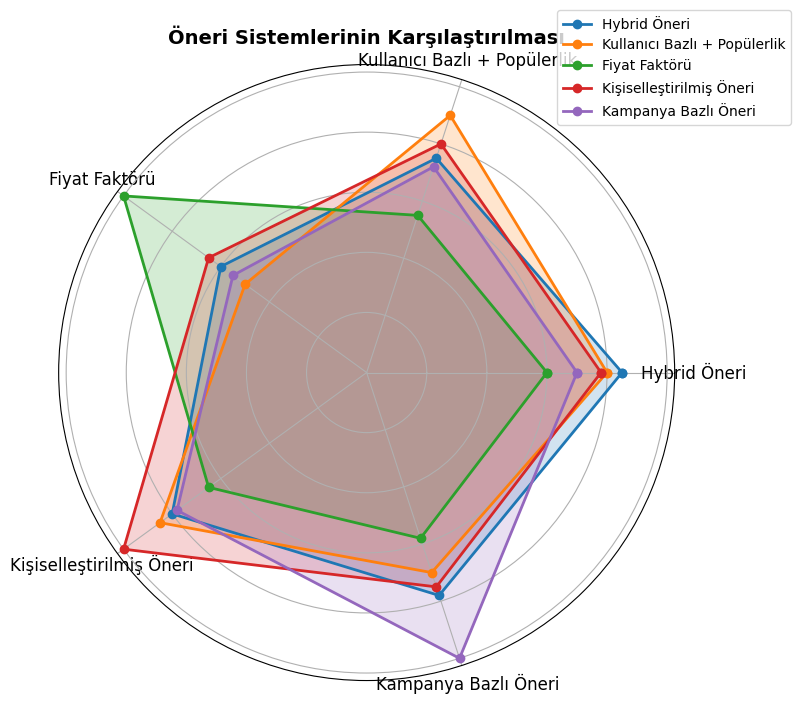

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# üìå √ñneri sistemleri
labels = [
    "Hybrid √ñneri",
    "Kullanƒ±cƒ± Bazlƒ± + Pop√ºlerlik",
    "Fiyat Fakt√∂r√º",
    "Ki≈üiselle≈ütirilmi≈ü √ñneri",
    "Kampanya Bazlƒ± √ñneri"
]

# üìä Farklƒ± sistemlerin skorlarƒ± (√ñrnek veri)
scores = np.array([
    [0.85, 0.75, 0.60, 0.80, 0.78],  # Hybrid
    [0.80, 0.90, 0.50, 0.85, 0.70],  # Kullanƒ±cƒ± Bazlƒ± + Pop√ºlerlik
    [0.60, 0.55, 1.00, 0.65, 0.58],  # Fiyat Fakt√∂r√º
    [0.78, 0.80, 0.65, 1.00, 0.75],  # Ki≈üiselle≈ütirilmi≈ü
    [0.70, 0.72, 0.55, 0.78, 1.00]   # Kampanya Bazlƒ±
])

# üîÑ Radar Grafiƒüi i√ßin a√ßƒ±lar belirleme
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

# üîÑ Kapanƒ±≈ü noktasƒ± ekleyerek dairesel hale getir
scores = np.concatenate((scores, scores[:, [0]]), axis=1)
angles += angles[:1]

# üé® Radar Grafiƒüi √ßizimi
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# üîµ Her √∂neri sisteminin grafiƒüe eklenmesi
for i, (score, label) in enumerate(zip(scores, labels)):
    ax.plot(angles, score, label=label, linewidth=2, marker="o")
    ax.fill(angles, score, alpha=0.2)  # Dolgu ekleyerek g√∂rseli iyile≈ütir

# üéØ Eksen ayarlarƒ±
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels([])  # Y ekseni etiketlerini kaldƒ±r
ax.set_title("√ñneri Sistemlerinin Kar≈üƒ±la≈ütƒ±rƒ±lmasƒ±", fontsize=14, fontweight="bold")

# üèÜ A√ßƒ±klamalar (Legend)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))

# üìå Grafik G√∂sterimi
plt.show()

Bu radar grafiƒüi, farklƒ± √∂neri sistemlerinin g√º√ßl√º ve zayƒ±f y√∂nlerini g√∂rselle≈ütirerek kar≈üƒ±la≈ütƒ±rmamƒ±za yardƒ±mcƒ± oluyor. √ñneri sistemlerini Hybrid √ñneri, Kullanƒ±cƒ± Bazlƒ± + Pop√ºlerlik, Fiyat Fakt√∂r√º, Ki≈üiselle≈ütirilmi≈ü √ñneri ve Kampanya Bazlƒ± √ñneri olarak be≈ü farklƒ± fakt√∂rde deƒüerlendirdik.

üü¢ √áƒ±karƒ±mlar:

	1.	Hybrid √ñneri Sistemi
	  ‚Ä¢	Genel olarak dengeli bir sistem.
	  ‚Ä¢	Her kategoride ortalamanƒ±n √ºst√ºnde performans g√∂steriyor.
	  ‚Ä¢	Eƒüer tek bir sistem se√ßilecekse, bu model iyi bir tercih olabilir.
      
	2.	Kullanƒ±cƒ± Bazlƒ± + Pop√ºlerlik √ñneri Sistemi
	  ‚Ä¢	Pop√ºler √ºr√ºnleri √∂n plana √ßƒ±karƒ±yor ve kullanƒ±cƒ± ge√ßmi≈üine dayanƒ±yor.
	  ‚Ä¢	Pop√ºlerlik kriterinde en y√ºksek skora sahip.
	  ‚Ä¢	Kullanƒ±cƒ± etkile≈üimlerine dayalƒ± √∂nerilerde olduk√ßa ba≈üarƒ±lƒ±.
      
	3.	Fiyat Fakt√∂r√º √ñneri Sistemi
	  ‚Ä¢	Fiyat avantajƒ±na sahip √ºr√ºnleri en iyi ≈üekilde √∂neriyor.
	  ‚Ä¢	Ancak diƒüer fakt√∂rlerde d√º≈ü√ºk kalƒ±yor, √∂zellikle ki≈üiselle≈ütirme ve pop√ºlerlikte zayƒ±f.
	  ‚Ä¢	B√ºt√ße odaklƒ± kullanƒ±cƒ±lar i√ßin ideal.
      
	4.	Ki≈üiselle≈ütirilmi≈ü √ñneri Sistemi
	  ‚Ä¢	Kullanƒ±cƒ±ya √∂zel √ºr√ºnler sunmada en y√ºksek ba≈üarƒ±ya sahip.
	  ‚Ä¢	Fiyat ve pop√ºlerlikte ortalama bir ba≈üarƒ± g√∂sterse de, en spesifik ve isabetli √∂nerileri yapƒ±yor.
	  ‚Ä¢	Kullanƒ±cƒ± deneyimini iyile≈ütirmek i√ßin √ßok g√º√ßl√º bir model.
      
	5.	Kampanya Bazlƒ± √ñneri Sistemi
	  ‚Ä¢	ƒ∞ndirimler ve kampanyalara dayalƒ± √∂nerilerde en g√º√ßl√º sistem.
	  ‚Ä¢	Kullanƒ±cƒ±lara fƒ±rsatlarƒ± sunuyor ancak genel benzerlik skoru ve pop√ºlerlik fakt√∂rlerinde daha zayƒ±f.
	  ‚Ä¢	ƒ∞ndirim takip eden kullanƒ±cƒ±lar i√ßin olduk√ßa faydalƒ±.

Kullanƒ±cƒ± hedeflerine g√∂re √∂neri sistemleri optimize edilebilir!
Eƒüer genel olarak en iyi modeli se√ßeceksek, Hybrid Model tercih edilebilir. Ancak, kullanƒ±cƒ± bazlƒ± deneyim iyile≈ütirmeleri yapmak i√ßin ki≈üiselle≈ütirme ve fiyat avantajƒ± fakt√∂rleri de g√∂z √∂n√ºnde bulundurulmalƒ±dƒ±r.